In [1]:
import os

os.environ["http_proxy"] = "http://proxy50.adm.toyota.co.jp:15520"
os.environ["https_proxy"] = "http://proxy50.adm.toyota.co.jp:15520"

In [5]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image
from matplotlib import pyplot as plt
import numpy
from torchvision import transforms as tfms

# For video display:
from IPython.display import HTML
from base64 import b64encode
from IPython.display import clear_output

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
# 潜在空間を画像空間にデコードするためのVAEモデルを読み込む
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_auth_token=True)

# トークナイズとテキストのエンコード用に、tokenizerと、text_encoderを読み込む
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 潜在空間を生成するためのU-Netモデルの指定
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", use_auth_token=True)

# ノイズスケジューラの指定
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# モデルをGPUへ移す
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)
clear_output()

print("=== End of loading ===")

=== End of loading ===


0it [00:00, ?it/s]

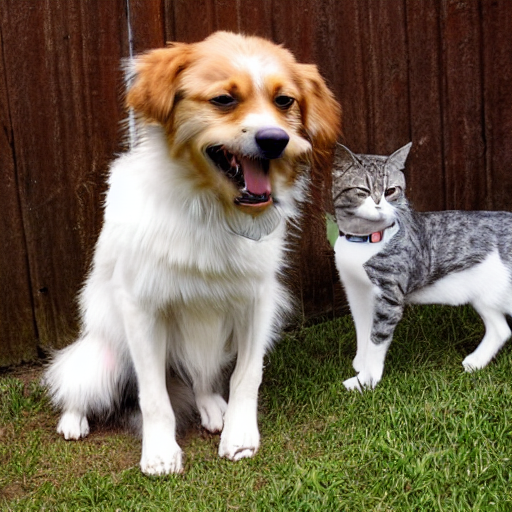

In [17]:
# 設定

#ランダム整数
import random
randomseed = random.randint(1, 100000)

prompt = ["dog and cat"]
height = 512                        # Stable Diffusion標準の出力画像サイズ (高さ)
width = 512                         # Stable Diffusion標準の出力画像サイズ (幅)
num_inference_steps = 30            # ノイズ除去のステップ数
guidance_scale = 7.5                # ガイダンスの強さ
generator = torch.manual_seed(randomseed)   # 潜在空間のノイズ生成のためのシード生成
batch_size = 1

# テキストの準備
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# スケジューラの準備
scheduler.set_timesteps(num_inference_steps)

# 潜在ベクトルの準備
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.sigmas[0] # Need to scale to match k

# ループの実行
with autocast("cuda"):
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        # 分類器不要のガイダンスを行う場合は、2回のフォワードパスを行わないように潜在ベクトルを拡張する
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

        # ノイズの残差を予測する
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # ガイダンスを実行する
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # ひとつ前のサンプルを計算する x_t -> x_t-1
        latents = scheduler.step(noise_pred, i, latents)["prev_sample"]

# 画像の拡大縮小とVAEによる復号化
latents = 1 / 0.18215 * latents

with torch.no_grad():
    image = vae.decode(latents)

# 生成画像の表示
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]